In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd "/content/drive/MyDrive/DDU+CE"

/content/drive/MyDrive/DDU+CE


In [3]:
import torch
import numpy as np


CE_dir = 'valset_batch/'
v = 'v'                 # 'v' if validation set examples (for loading arrays)
batch_size = 100

device = 'cuda' if torch.cuda.is_available() else 'cpu'

labels = torch.load(CE_dir + f'orig_batch_{batch_size}{v}_y.pt').to(device)
labels_exp = torch.load(CE_dir + f'orig_batch_{batch_size}{v}_y.pt').unsqueeze(1).expand(batch_size, 10)
targets = torch.tensor(range(10)).unsqueeze(0).expand(labels_exp.size())

print('device: ', device)

device:  cpu


# Analysis

In [4]:
targets = torch.tensor(range(10)).unsqueeze(0).expand(labels_exp.size())
originals = torch.load(CE_dir + f'orig_batch_{batch_size}{v}_X.pt')
orig_exp = originals.expand(100,10,28,28)

iter = {}
im = {}
L0 = {}
L1 = {}
mask = {}

### SN coefficient

In [5]:
mom = 0
pix = ''
cl = 'cl1'

for coeff in [2,3,4,5]:

  method = f'SN c{coeff}{pix}{cl}m{mom}'
  max_iter = 700

  iter[method] = torch.load(CE_dir + f'iter_{v}batch_c{int(coeff)}m{mom}{cl}{pix}.pt')
  im[method] = torch.load(CE_dir + f'arr_{v}batch_c{int(coeff)}m{mom}{cl}{pix}.pt').reshape(100,10,28,28) #.permute(0,2,1)
  L0[method] = (im[method] != orig_exp).sum(dim=(2,3))
  L1[method] = torch.sum((im[method] - orig_exp).abs(), dim=(2,3))
  mask[method] = (targets != labels_exp) & (iter[method] < max_iter)

### loss function

In [6]:
coeff = 4
mom = 0
pix = ''

for cl in ['CL1','CL10','CL100','CL1000','CL10000','CL100000']:

  method = f'L c{coeff}{pix}{cl}m{mom}'
  max_iter = 700

  iter[method] = torch.load(CE_dir + f'iter_{v}batch_c{int(coeff)}m{mom}{cl}{pix}.pt')
  im[method] = torch.load(CE_dir + f'arr_{v}batch_c{int(coeff)}m{mom}{cl}{pix}.pt').reshape(100,10,28,28) #.permute(0,2,1)
  L0[method] = (im[method] != orig_exp).sum(dim=(2,3))
  L1[method] = torch.sum((im[method] - orig_exp).abs(), dim=(2,3))
  mask[method] = (targets != labels_exp) & (iter[method] < max_iter)

In [7]:
coeff = 4
mom = 0
pix = ''

for cl in ['', 'cl0.2', 'cl5.0']:

  method = f'L c{coeff}{pix}{cl}m{mom}'
  max_iter = 700

  iter[method] = torch.load(CE_dir + f'iter_{v}batch_c{int(coeff)}m{mom}{cl}{pix}.pt')
  im[method] = torch.load(CE_dir + f'arr_{v}batch_c{int(coeff)}m{mom}{cl}{pix}.pt').reshape(100,10,28,28) #.permute(0,2,1)
  L0[method] = (im[method] != orig_exp).sum(dim=(2,3))
  L1[method] = torch.sum((im[method] - orig_exp).abs(), dim=(2,3))
  mask[method] = (targets != labels_exp) & (iter[method] < max_iter)

### number of pixels

In [8]:
coeff = 4
mom = 0
cl = 'cl1'

for pix in ['p2', 'p3']:

  method = f'P c{coeff}{pix}{cl}m{mom}'
  max_iter = 700

  iter[method] = torch.load(CE_dir + f'iter_{v}batch_c{int(coeff)}m{mom}{cl}{pix}.pt')
  im[method] = torch.load(CE_dir + f'arr_{v}batch_c{int(coeff)}m{mom}{cl}{pix}.pt').reshape(100,10,28,28) #.permute(0,2,1)
  L0[method] = (im[method] != orig_exp).sum(dim=(2,3))
  L1[method] = torch.sum((im[method] - orig_exp).abs(), dim=(2,3))
  mask[method] = (targets != labels_exp) & (iter[method] < max_iter)

### momentum

In [9]:
coeff = 4
pix = ''
cl = 'cl1.0'

for mom in range(1,10):

  method = f'M c{coeff}{pix}{cl}m{mom}'
  max_iter = 700

  iter[method] = torch.load(CE_dir + f'iter_{v}batch_c{int(coeff)}m{mom}{cl}{pix}.pt')
  im[method] = torch.load(CE_dir + f'arr_{v}batch_c{int(coeff)}m{mom}{cl}{pix}.pt').reshape(100,10,28,28) #.permute(0,2,1)
  L0[method] = (im[method] != orig_exp).sum(dim=(2,3))
  L1[method] = torch.sum((im[method] - orig_exp).abs(), dim=(2,3))
  mask[method] = (targets != labels_exp) & (iter[method] < max_iter)

In [14]:
for mm in range(1,10):
  diff = (im['SN c4cl1m0'] != im[f'M c4cl1.0m{mm}']).reshape(100,10,28*28).any(2).sum().item()
  print(f'differences from momentum 0.{mm}: {diff}/900 = {diff/900}')

differences from momentum 0.1: 0/900 = 0.0
differences from momentum 0.2: 0/900 = 0.0
differences from momentum 0.3: 0/900 = 0.0
differences from momentum 0.4: 3/900 = 0.0033333333333333335
differences from momentum 0.5: 6/900 = 0.006666666666666667
differences from momentum 0.6: 12/900 = 0.013333333333333334
differences from momentum 0.7: 22/900 = 0.024444444444444446
differences from momentum 0.8: 25/900 = 0.027777777777777776
differences from momentum 0.9: 36/900 = 0.04


## show images

In [12]:
import matplotlib.pyplot as plt
plt.gray()

n_rows = len(im) + 1

def r2(x):
    return np.round(x.numpy(), 2)


target = 6

fig = plt.figure(figsize=(100, n_rows*10))
num=10
start = 20

for i in range(num):
    ax = plt.subplot2grid((n_rows,num), (0, i))
    plt.imshow(originals[start+i].view(28,28))
    plt.axis('off')

k = 1
for method in im.keys():
  for i in range(num):
      ax = plt.subplot2grid((n_rows,num), (k, i))
      plt.imshow(im[method][start+i,target])
      plt.axis('off')
  k += 1
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

In [13]:
def r2mean(x):
    return np.round(x.mean().item(), 2)
def r2std(x):
    return np.round(x.std().item(), 2)

mask_all = mask['SN c4cl1m0'] #& mask['c4cl1m0']& mask['c4cl1m1']& mask['c4cl1m3']& mask['c4cl1m3']& mask['c4cl1m4'] # compare on same examples
for alg in im.keys():
  mask_all = mask_all & mask[alg]

for alg in im.keys():
  print(alg, '  L0: ', r2mean(L0[alg][mask_all].float()), '  L1: ', r2mean(L1[alg][mask_all]), '  good:', mask[alg].sum().item())
  
# STDs
print('STDs:')
for alg in im.keys():
  print(alg, '  L0: ', r2std(L0[alg][mask_all].float()),  '  L1: ', r2std(L1[alg][mask_all]))

SN c2cl1m0   L0:  26.12   L1:  11.38   good: 898
SN c3cl1m0   L0:  23.35   L1:  11.66   good: 900
SN c4cl1m0   L0:  24.47   L1:  12.32   good: 900
SN c5cl1m0   L0:  24.81   L1:  12.68   good: 900
L c4CL1m0   L0:  27.29   L1:  13.45   good: 899
L c4CL10m0   L0:  27.16   L1:  13.4   good: 899
L c4CL100m0   L0:  25.88   L1:  12.92   good: 900
L c4CL1000m0   L0:  24.58   L1:  12.38   good: 900
L c4CL10000m0   L0:  25.1   L1:  12.53   good: 900
L c4CL100000m0   L0:  25.38   L1:  12.65   good: 900
L c4m0   L0:  27.36   L1:  13.47   good: 899
L c4cl0.2m0   L0:  25.45   L1:  12.75   good: 900
L c4cl5.0m0   L0:  24.92   L1:  12.46   good: 899
P c4p2cl1m0   L0:  26.27   L1:  12.62   good: 900
P c4p3cl1m0   L0:  27.94   L1:  12.91   good: 900
M c4cl1.0m1   L0:  24.47   L1:  12.32   good: 900
M c4cl1.0m2   L0:  24.47   L1:  12.32   good: 900
M c4cl1.0m3   L0:  24.47   L1:  12.32   good: 900
M c4cl1.0m4   L0:  24.45   L1:  12.32   good: 900
M c4cl1.0m5   L0:  24.44   L1:  12.32   good: 900
M c4cl1.

## SN coeff

5 1


<Figure size 432x288 with 0 Axes>

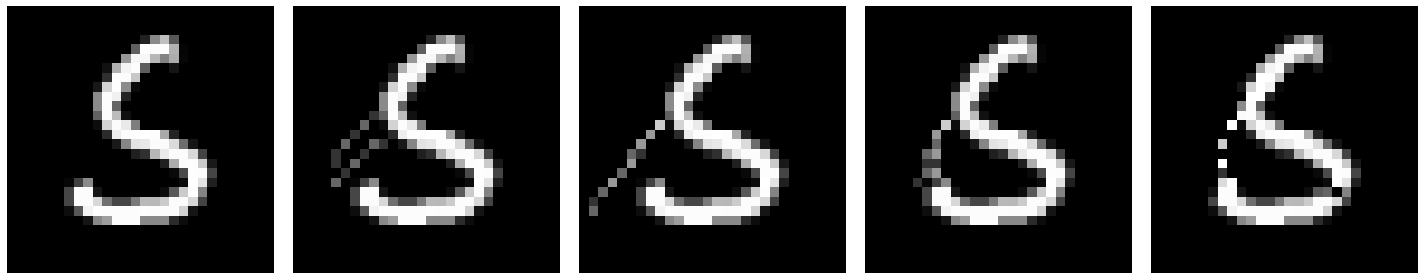

In [16]:
import matplotlib.pyplot as plt
plt.gray()


n_rows = 1
n_cols = 5

fig = plt.figure(figsize=(n_cols*4, n_rows*4))
print(n_cols, n_rows)

ax = plt.subplot2grid((n_rows,n_cols), (0, 0),fig=fig)
plt.imshow(originals[25].view(28,28))
plt.axis('off')

k=1
for method in im.keys():
  if method.startswith('SN'):
    ax = plt.subplot2grid((n_rows,n_cols), (0, k))
    plt.imshow(im[method][25,6])
    plt.axis('off')
    k += 1

plt.tight_layout()